In [1]:
from google.colab import files
data = files.upload()
# "genre_lyrics_data.csv"

Saving genre_lyrics_data.csv to genre_lyrics_data (1).csv


In [2]:
import pandas as pd
df = pd.read_csv("genre_lyrics_data.csv")

In [3]:
df = df[["genre_name","lyrics_cleaned"]]
df.rename(columns={"lyrics_cleaned":"lyrics"},inplace=True)
df.head()

,genre_name,lyrics
0,acoustic,well you done done me and you bet i felt it i ...
1,acoustic,head under water and they tell me to breathe e...
2,acoustic,will you count me in ive been awake for a whil...
3,acoustic,do you hear me im talking to you across the wa...
4,acoustic,the strands in your eyes that color them wonde...


In [4]:
# reference https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

from io import StringIO
df['category_id'] = df["genre_name"].factorize()[0]
category_to_id = df[['genre_name','category_id']].drop_duplicates().sort_values('category_id')
id_to_category = dict(category_to_id[['category_id', 'genre_name']].values)
df.head()

,genre_name,lyrics,category_id
0,acoustic,well you done done me and you bet i felt it i ...,0
1,acoustic,head under water and they tell me to breathe e...,0
2,acoustic,will you count me in ive been awake for a whil...,0
3,acoustic,do you hear me im talking to you across the wa...,0
4,acoustic,the strands in your eyes that color them wonde...,0


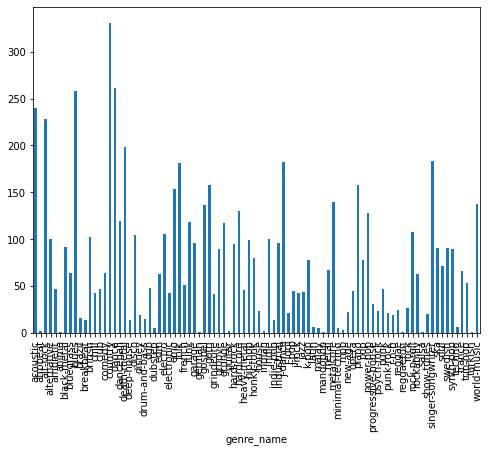

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('genre_name').lyrics.count().plot.bar(ylim=0)
plt.show()

In [6]:
genre_size = df.groupby('genre_name').lyrics.count()

In [7]:
genre_size.sort_values(ascending=False).head(30)

genre_name
country              331
dance                261
blues                258
acoustic             240
alt-rock             228
death-metal          198
singer-songwriter    183
j-dance              182
folk                 181
piano                158
goth                 158
emo                  154
metalcore            140
world-music          138
gospel               137
hardcore             130
power-pop            128
dancehall            119
funk                 118
grunge               117
rock-n-roll          108
electro              106
disco                105
british              102
indie                100
alternative          100
hip-hop               99
industrial            96
garage                96
hard-rock             95
Name: lyrics, dtype: int64

In [8]:
top_30 = list(genre_size.head(30).index)
top_30_df = df.loc[df['genre_name'].isin(top_30)]
len(top_30_df)
df = top_30_df.copy()

category_to_id = df[['genre_name','category_id']].drop_duplicates().sort_values('category_id')
id_to_category = dict(category_to_id[['category_id', 'genre_name']].values)

In [25]:
id_to_category

{0: 'acoustic',
 1: 'afrobeat',
 2: 'alt-rock',
 3: 'alternative',
 4: 'ambient',
 5: 'anime',
 6: 'black-metal',
 7: 'bluegrass',
 8: 'blues',
 9: 'brazil',
 10: 'breakbeat',
 11: 'british',
 12: 'chill',
 13: 'club',
 14: 'comedy',
 15: 'country',
 16: 'dance',
 17: 'dancehall',
 18: 'death-metal',
 19: 'deep-house',
 20: 'disco',
 21: 'disney',
 22: 'drum-and-bass',
 23: 'dub',
 24: 'dubstep',
 25: 'edm',
 26: 'electro',
 27: 'electronic',
 28: 'emo',
 29: 'folk'}

In [10]:
len(df.genre_name.unique())

30

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.lyrics).toarray()
labels = df.category_id
features.shape

(2980, 162308)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecate

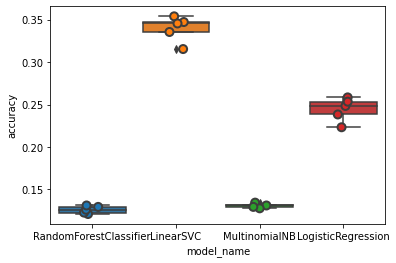

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [14]:
 cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.339597
LogisticRegression        0.244295
MultinomialNB             0.130537
RandomForestClassifier    0.125839
Name: accuracy, dtype: float64

In [15]:
len(df.genre_name.unique())

30

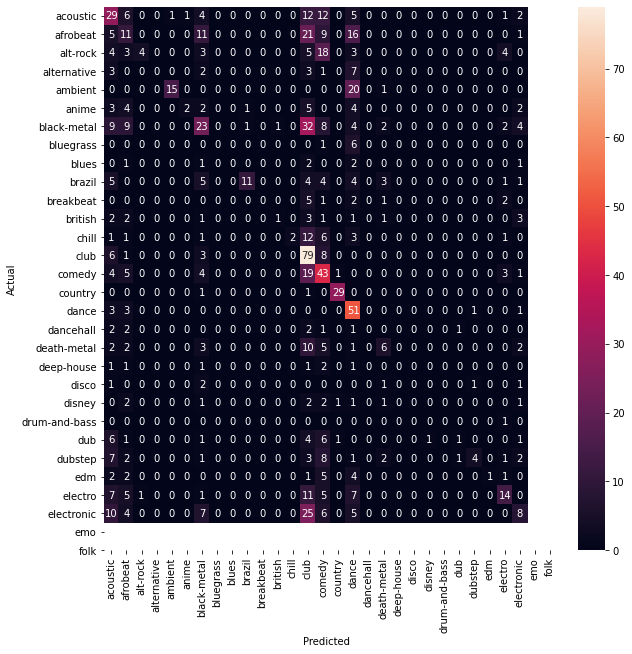

In [46]:
plt.close()
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_to_id.genre_name.values, yticklabels=category_to_id.genre_name.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [17]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
# import pickle
# # save the model to disk
# filename = 'full_genre_model.sav'
# pickle.dump(model, open(filename, 'wb'))

In [53]:
import pickle
# save the model to disk
filename = 'top30_genre_model.pickle'
pickle.dump(model, open(filename, 'wb'))
# save vectorizer
pickle.dump(tfidf, open("vectorizer.pickle", "wb"))
# save translation dict
pickle.dump(id_to_category, open('genre_dict.csv', 'wb'))

In [49]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_tfidf= pickle.load(open("vectorizer.pickle", "rb"))
genre_dict = pickle.load(open("genre_dict.csv", "rb"))

In [50]:
result = loaded_model.score(X_test, y_test)
print(result)

0.3394308943089431


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
user_lyric = 'pizza i love it'
# cleaned_lyric = clean_text(user_lyric)

X_test = loaded_tfidf.transform([user_lyric])
prediction = loaded_model.predict(X_test)
# check with labelled data

In [52]:
genre_dict[prediction[0]]

'folk'